In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import kt_utils 

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = kt_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


# Model:
optimizer：优化器，为预定义优化器名或优化器对象，参考优化器

loss：损失函数，为预定义损失函数名或一个目标函数，参考损失函数

metrics：列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=['accuracy']如果要在多输出模型中为不同的输出指定不同的指标，可像该参数传递一个字典，例如metrics={'ouput_a': 'accuracy'}

sample_weight_mode：如果你需要按时间步为样本赋权（2D权矩阵），将该值设为“temporal”。默认为“None”，代表按样本赋权（1D权）。如果模型有多个输出，可以向该参数传入指定sample_weight_mode的字典或列表。在下面fit函数的解释中有相关的参考内容。

weighted_metrics: metrics列表，在训练和测试过程中，这些metrics将由sample_weight或clss_weight计算并赋权

target_tensors: 默认情况下，Keras将为模型的目标创建一个占位符，该占位符在训练过程中将被目标数据代替。如果你想使用自己的目标张量（相应的，Keras将不会在训练时期望为这些目标张量载入外部的numpy数据），你可以通过该参数手动指定。目标张量可以是一个单独的张量（对应于单输出模型），也可以是一个张量列表，或者一个name->tensor的张量字典。

kwargs：使用TensorFlow作为后端请忽略该参数，若使用Theano/CNTK作为后端，kwargs的值将会传递给 K.function。如果使用TensorFlow为后端，这里的值会被传给tf.Session.run

当为参数传入非法值时会抛出异常

【Tips】如果你只是载入模型并利用其predict，可以不用进行compile。在Keras中，compile主要完成损失函数和优化器的一些配置，是为训练服务的。predict会在内部进行符号函数的编译工作（通过调用_make_predict_function生成函数）

# fit
本函数用以训练模型，参数有：

x：输入数据。如果模型只有一个输入，那么x的类型是numpy array，如果模型有多个输入，那么x的类型应当为list，list的元素是对应于各个输入的numpy array。如果模型的每个输入都有名字，则可以传入一个字典，将输入名与其输入数据对应起来。

y：标签，numpy array。如果模型有多个输出，可以传入一个numpy array的list。如果模型的输出拥有名字，则可以传入一个字典，将输出名与其标签对应起来。

batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。

epochs：整数，训练终止时的epoch值，训练将在达到该epoch值时停止，当没有设置initial_epoch时，它就是训练的总轮数，否则训练的总轮数为epochs - inital_epoch

verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录

callbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数

validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，如损失函数、精确度等。注意，validation_split的划分在shuffle之后，因此如果你的数据本身是有序的，需要先手工打乱再指定validation_split，否则可能会出现验证集样本不均匀。

validation_data：形式为（X，y）或（X，y，sample_weights）的tuple，是指定的验证集。此参数将覆盖validation_spilt。

shuffle：布尔值，表示是否在训练过程中每个epoch前随机打乱输入样本的顺序。

class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）。该参数在处理非平衡的训练数据（某些类的训练样本数很少）时，可以使得损失函数对样本数不足的数据更加关注。

sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权。这种情况下请确定在编译模型时添加了sample_weight_mode='temporal'。

initial_epoch: 从该参数指定的epoch开始训练，在继续之前的训练时有用。

steps_per_epoch: 一个epoch包含的步数（每一步是一个batch的数据送入），当使用如TensorFlow数据Tensor之类的输入张量进行训练时，默认的None代表自动分割，即数据集样本数/batch样本数。

validation_steps: 仅当steps_per_epoch被指定时有用，在验证集上的step总数。
输入数据与规定数据不匹配时会抛出错误

fit函数返回一个History的对象，其History.history属性记录了损失函数和其他指标的数值随epoch变化的情况，如果有验证集的话，也包含了验证集的这些指标变化情况

# Evaluate
本函数按batch计算在某些输入数据上模型的误差，其参数有：

x：输入数据，与fit一样，是numpy array或numpy array的list

y：标签，numpy array

batch_size：整数，含义同fit的同名参数

verbose：含义同fit的同名参数，但只能取0或1

sample_weight：numpy array，含义同fit的同名参数

本函数返回一个测试误差的标量值（如果模型没有其他评价指标），或一个标量的list（如果模型还有其他的评价指标）。model.metrics_names将给出list中各个值的含义。

如果没有特殊说明，以下函数的参数均保持与fit的同名参数相同的含义

如果没有特殊说明，以下函数的verbose参数（如果有）均只能取0或1

# Predict
本函数按batch获得输入数据对应的输出，其参数有：

函数的返回值是预测值的numpy array

In [3]:
def HappyModel(input_shape):
    """
    实现一个检测笑容的模型
    
    参数：
        input_shape - 输入的数据的维度
    返回：
        model - 创建的Keras的模型
        
    """
    X_input = Input(input_shape)
    
    
    #使用0填充
    X = ZeroPadding2D((3,3))(X_input)
    
    #对X使用CONV->BN->RELU         32是#filters; (7,7)=(f,f)
    X = Conv2D(32,(7,7),strides=(1,1),name="con0")(X)  
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    #最大值池化层
    X = MaxPooling2D((2,2), name='max_pool')(X)
    
    #降维，矩阵转化为向量 + fc
    X = Flatten()(X)
    X = Dense(1, activation="sigmoid",name='fc')(X)
    
    #创建一个模型，用来训练
    model = Model(inputs=X_input,outputs=X,name='HappyModel')
    
    return model

In [4]:
#创建一个模型实体
happy_model = HappyModel(X_train.shape[1:])
#编译模型
happy_model.compile('adam',"binary_crossentropy",metrics=['accuracy'])
#训练模型
happy_model.fit(X_train,Y_train,epochs=1,batch_size=50)
#评估模型
preds = happy_model.evaluate(X_test,Y_test,batch_size=32,verbose=1,sample_weight=None)
print("误差值 = " + str(preds[0]))
print("准确度 = " + str(preds[1]))

5/5 [==============================] - 0s 48ms/step - loss: 0.6233 - accuracy: 0.6533
误差值 = 0.623260498046875
准确度 = 0.653333306312561


In [5]:
happy_model.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
con0 (Conv2D)                (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

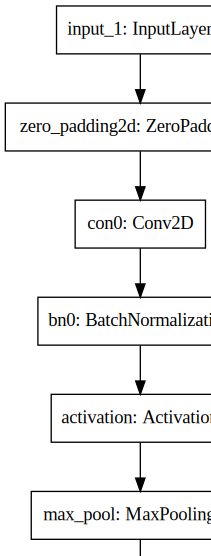

In [7]:
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))